In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

In [2]:
appn = pdr.get_data_yahoo('APPN','2019-05-31')
appn.drop('Adj Close', axis=1, inplace=True)
appn.head()

,High,Low,Open,Close,Volume
Date,,,,,
2019-05-31,36.520000,35.436001,35.520000,36.130001,331800
2019-06-03,36.570000,32.650002,36.000000,33.299999,677900
2019-06-04,34.560001,33.459999,33.919998,34.360001,507700
2019-06-05,34.790001,33.040001,34.540001,34.730000,445500
2019-06-06,34.480000,33.150002,34.060001,34.220001,326800


In [34]:
appn['3-day'] = appn['Close'].rolling(3).mean()
appn['9-day'] = appn['Close'].rolling(9).mean()
appn['21-day'] = appn['Close'].rolling(21).mean()
appn['Change'] = np.log(appn.Close / appn.Close.shift())
appn.tail()

,High,Low,Open,Close,Volume,9-day,21-day,Change,position,system,9-day-dgim,21-day-dgim,position-dgim,system-dgim,3-day
Date,,,,,,,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,84.880000,90.346190,0.023709,-1,0.000000,66.222222,72.190476,-1,0.0,88.220001
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,85.348889,88.746190,-0.032576,-1,0.000000,65.888889,70.619048,-1,0.0,88.806669
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,86.631111,87.721428,0.070423,-1,0.000000,67.222222,69.428571,-1,0.0,90.676669
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,87.454445,87.013333,-0.027621,1,-0.027621,68.000000,70.238095,-1,0.0,90.986669
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,88.414445,86.472857,-0.004935,1,-0.004935,68.888889,69.904762,-1,0.0,92.113335


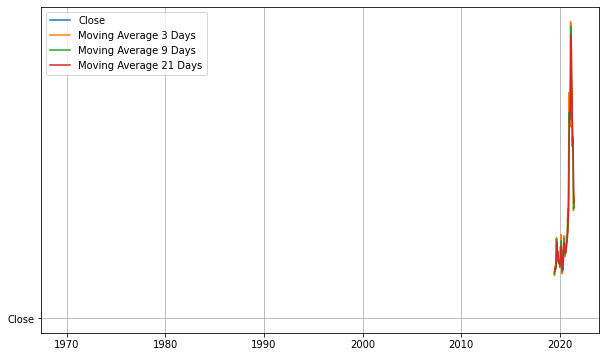

In [35]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(['Close'],label='Close')
plt.plot(appn['3-day'],label='Moving Average 3 Days')
plt.plot(appn['9-day'],label='Moving Average 9 Days')
plt.plot(appn['21-day'],label='Moving Average 21 Days')
plt.legend(loc=2)

## Zoom in the changing period

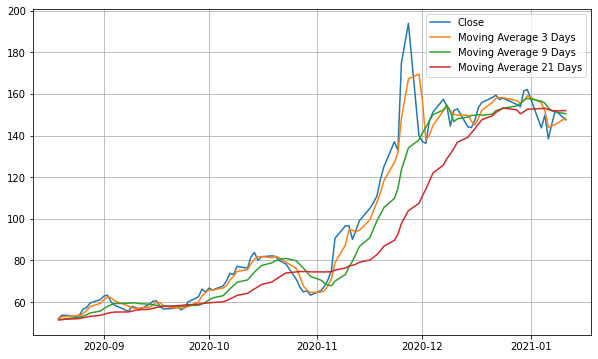

In [36]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

In [6]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position'] = np.where(appn['9-day'] > appn['21-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position'] = np.where(appn['9-day'] < appn['21-day'],-1,appn['position'])

<AxesSubplot:xlabel='Date'>

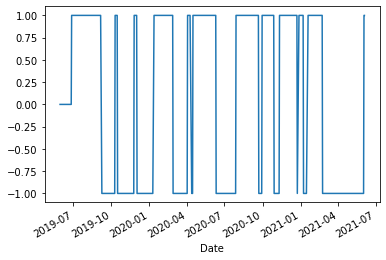

In [7]:
appn['position'].plot()

<AxesSubplot:xlabel='Date'>

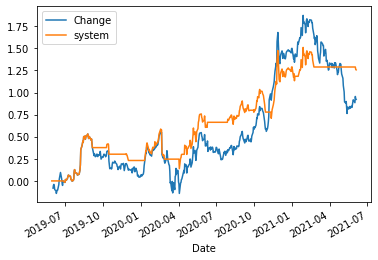

In [32]:
# Whether we are making money with this system
appn['system'] = np.where(appn['position'] > 0, appn['position']* appn['Change'],0)
appn[['Change','system']].cumsum().plot()

<AxesSubplot:xlabel='Date'>

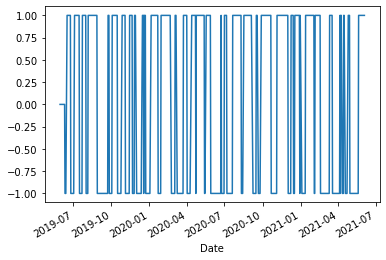

In [47]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-3-9'] = np.where(appn['3-day'] > appn['9-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-3-9'] = np.where(appn['3-day'] < appn['9-day'],-1,appn['position-3-9'])
appn['position-3-9'].plot()

<AxesSubplot:xlabel='Date'>

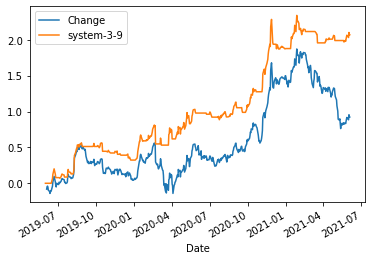

In [48]:
# Whether we are making money with this system
appn['system-3-9'] = np.where(appn['position-3-9'] > 0, appn['position-3-9']* appn['Change'],0)
appn[['Change','system-3-9']].cumsum().plot()

In [37]:
bit_depth = 16
appn_list = appn['Close'].tolist()
appn_3day_list = appn['3-day'].tolist()
appn_9day_list = appn['9-day'].tolist()
appn_21day_list = appn['21-day'].tolist()
appn_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in appn_list ]
print(appn_list[0],appn_list_bin[0], len(appn_list_bin))

36.130001068115234 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] 508


In [10]:
import math
import copy

class DGIM:
    buckets = []
    times = {}
    bits = []
    value = 0
    num_buckets = 0
    
    def __init__(self, num_buckets, snapshot):
        self.buckets.clear()
        self.times.clear()
        self.bits.clear()
        for b in range(num_buckets):
            self.buckets.append(0)
        for d in range(bit_depth):
            self.bits.append(0)
        self.num_buckets = num_buckets
        s = copy.deepcopy(snapshot)
        s.reverse()
        for b in s:
            self.add_bit(b)
    
    def calc_value(self):
        v = 0
        for i in range(self.num_buckets):
            if i == self.num_buckets-1 and self.buckets[i] > 0:
                v += pow(2,i)*self.buckets[i]
                v -= pow(2,i)/2
            elif (self.buckets[i] > 0):
                v += pow(2,i)*self.buckets[i]
                if (self.buckets[i+1] == 0):
                    v -= pow(2,i)/2
        self.value = math.ceil(v)
        
    def add_bit(self,bit):
        
        self.bits.insert(0,bit);
        self.bits = self.bits[0:-1]
        
        if bit == 1:
            self.buckets[0] += 1
        for i in range(self.num_buckets):
            if self.buckets[i] > 2:
                self.buckets[i] -= 2
                try:
                    self.buckets[i+1] += 1
                except:
                    pass
        if self.buckets[-1] > 2:
            self.buckets[-1] = 2
        
        self.calc_value()

In [11]:
class DGIMMovingAverage:
    
    streams = []
    mov_avg = []
    error = []
    
    def __init__(self, window_size, ground_truth=None, quiet=True):
        self.streams.clear()
        self.mov_avg.clear()
        self.error.clear()
        for i in range(bit_depth):
            tmp = []
            for w in range(window_size):
                tmp.append(0)
            self.streams.append(tmp)

        for d in range(len(appn_list_bin)):
            day = appn_list_bin[d]
            counts = []
            for i in range(len(day)):
                self.streams[i].insert(0,day[i])
                self.streams[i] = self.streams[i][0:window_size]
                tmp = DGIM(5,self.streams[i])
                counts.insert(0,tmp.value)
            total = 0
            for i in range(len(counts)):
                total += counts[i]*pow(2,i)
            if not quiet:
                print(d, ground_truth[d], total/window_size, 100*(total/window_size-ground_truth[d])/ground_truth[d])
            self.mov_avg.append(total/window_size if d >= window_size else None)
            self.error.append(100*(total/window_size-ground_truth[d])/ground_truth[d])


0 nan 4.0 nan
1 nan 7.666666666666667 nan
2 nan 7.888888888888889 nan
3 nan 11.777777777777779 nan
4 nan 15.333333333333334 nan
5 nan 18.88888888888889 nan
6 nan 18.88888888888889 nan
7 nan 22.333333333333332 nan
8 33.46777809990777 25.88888888888889 -22.64533124486016
9 33.075555589463974 25.555555555555557 -22.735823782515293
10 32.98666678534614 25.444444444444443 -22.864457297189606
11 33.02222230699327 25.555555555555557 -22.61103653783005
12 33.252222273084854 25.77777777777778 -22.478029991267892
13 33.64555528428819 25.77777777777778 -23.38429976866665
14 34.31777784559462 26.444444444444443 -22.94243361727711
15 35.1488889058431 27.333333333333332 -22.235569361654907
16 35.752222273084854 28.0 -21.683189967525223
17 36.097777472602 28.333333333333332 -21.50947975997091
18 36.29000006781684 28.444444444444443 -21.619056513394977
19 36.687778049045136 28.88888888888889 -21.257458409529455
20 36.842222425672745 29.0 -21.285964606217817
21 36.701111263699005 28.88888888888889 -21.

194 46.476666344536675 36.77777777777778 -20.86829656597993
195 46.03777737087674 36.333333333333336 -21.07930615191337
196 45.52555508083768 35.77777777777778 -21.411660518474097
197 44.53999922010634 35.44444444444444 -20.421093253086458
198 43.40777715047201 34.55555555555556 -20.393169556299643
199 41.786666022406685 33.333333333333336 -20.22973712365695
200 40.127777099609375 31.22222222222222 -22.192993285625693
201 38.19222174750434 29.333333333333332 -23.195530421714444
202 36.999999576144745 28.555555555555557 -22.822821938715993
203 36.118888431125214 28.555555555555557 -20.94010420611949
204 34.96444405449761 27.444444444444443 -21.507562363445736
205 34.69666629367404 26.77777777777778 -22.82319704397667
206 35.03777737087674 27.11111111111111 -22.623199456579233
207 35.69666629367404 27.77777777777778 -22.183832100028916
208 36.44222174750434 28.555555555555557 -21.641562489226892
209 36.984444088406036 29.11111111111111 -21.288228527850375
210 37.949999491373696 29.111111

346 72.4977781507704 56.666666666666664 -21.836685051479066
347 74.3933334350586 58.666666666666664 -21.139887194489635
348 75.97666676839192 58.44444444444444 -23.0757982281493
349 77.53777821858723 60.0 -22.618365681237826
350 78.87666659884982 61.333333333333336 -22.241473964332442
351 79.77555592854817 62.22222222222222 -22.003398788029482
352 80.53333367241754 62.111111111111114 -22.875276262922156
353 80.75777774386935 62.333333333333336 -22.814451963959215
354 80.98333316379123 62.55555555555556 -22.75502487773001
355 79.77444373236762 63.111111111111114 -20.888058683504845
356 77.92777760823567 60.888888888888886 -21.864974521673076
357 76.23888821072049 59.22222222222222 -22.320191686774145
358 74.42444356282552 57.55555555555556 -22.665789893383696
359 72.32444381713867 54.55555555555556 -24.568302670268768
360 70.5033327738444 54.55555555555556 -22.61989127442386
361 69.11999977959528 53.22222222222222 -23.000256956115027
362 68.17000028822157 53.22222222222222 -21.927208453

486 123.22111341688368 94.55555555555556 -23.263511476597635
487 119.82889048258464 91.0 -24.05838055120313
488 114.47444491916232 92.77777777777777 -18.95328442667352
489 109.12444390190973 87.44444444444444 -19.867225602499385
490 103.93666500515408 82.55555555555556 -20.571286800993917
491 99.01110924614801 78.11111111111111 -21.108740518276743
492 94.1566645304362 72.77777777777777 -22.705654304213052
493 90.57555389404297 69.22222222222223 -23.575159912132893
494 87.82222069634332 70.11111111111111 -20.167002661513944
495 85.71666547987196 66.55555555555556 -22.354007609892186
496 83.88333214653863 64.77777777777777 -22.776341711586664
497 83.40888807508681 64.77777777777777 -22.337080288777898
498 82.86666615804036 64.66666666666667 -21.962992280470527
499 82.34666612413194 63.666666666666664 -22.684584982841276
500 82.38999938964844 63.666666666666664 -22.72524925559617
501 83.31555514865451 64.44444444444444 -22.65016499084664
502 83.88222164577908 65.33333333333333 -22.1130150

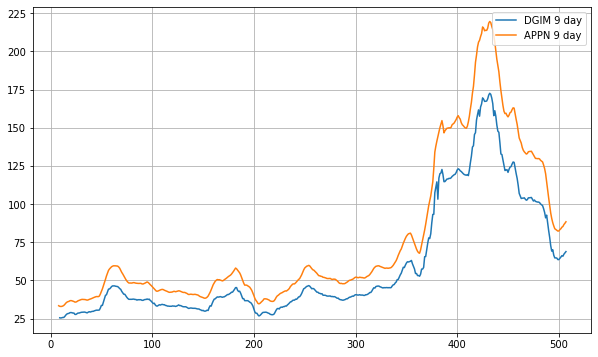

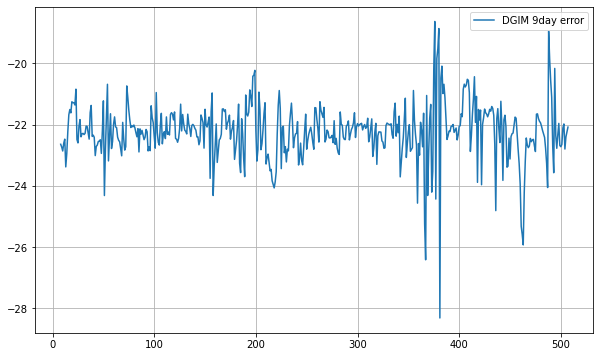

In [21]:
dgim_9day = DGIMMovingAverage(9, appn_9day_list, False)
appn['9-day-dgim'] = dgim_9day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_9day.mov_avg)), dgim_9day.mov_avg, label = "DGIM 9 day")
plt.plot(range(len(dgim_9day.mov_avg)), appn_9day_list, label = "APPN 9 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_9day.error)), dgim_9day.error, label = "DGIM 9day error")
plt.legend(loc=1)

0 nan 1.7142857142857142 nan
1 nan 3.2857142857142856 nan
2 nan 3.380952380952381 nan
3 nan 5.0476190476190474 nan
4 nan 6.571428571428571 nan
5 nan 8.095238095238095 nan
6 nan 8.095238095238095 nan
7 nan 9.571428571428571 nan
8 nan 11.095238095238095 nan
9 nan 12.666666666666666 nan
10 nan 14.19047619047619 nan
11 nan 15.857142857142858 nan
12 nan 17.38095238095238 nan
13 nan 19.19047619047619 nan
14 nan 20.952380952380953 nan
15 nan 19.80952380952381 nan
16 nan 21.571428571428573 nan
17 nan 23.238095238095237 nan
18 nan 24.857142857142858 nan
19 nan 26.38095238095238 nan
20 34.88428588140579 28.095238095238095 -19.461621800853397
21 34.855714343843005 28.095238095238095 -19.39560377938172
22 34.96190479823521 28.238095238095237 -19.231817027541858
23 35.072857084728426 28.38095238095238 -19.080010184542008
24 35.14999989100865 28.428571428571427 -19.122129397663407
25 35.29428554716564 28.666666666666668 -18.77816416383364
26 35.54428554716564 28.80952380952381 -18.947523164321623
27

195 51.147142682756694 41.333333333333336 -19.18740487673792
196 50.47380937848772 40.61904761904762 -19.5245056412173
197 49.56428545997257 39.714285714285715 -19.873180162440907
198 48.604285467238654 38.76190476190476 -20.25002653720334
199 47.41142836071196 37.57142857142857 -20.754489222344166
200 46.27333304995582 37.95238095238095 -17.982175800026617
201 44.76095217750186 36.476190476190474 -18.508904074376566
202 43.489523569742836 35.19047619047619 -19.082865706628667
203 42.19142822992234 33.857142857142854 -19.753503786033896
204 41.43428530011858 33.857142857142854 -18.287131992485563
205 41.01619012015207 33.42857142857143 -18.499082116972854
206 40.59333292643229 33.0 -18.70586221681714
207 40.333332970028835 32.76190476190476 -18.772136222291135
208 40.046666281563894 32.476190476190474 -18.904134871417764
209 39.88714236304874 32.333333333333336 -18.937954895242676
210 39.617618560791016 32.04761904761905 -19.107659137957082
211 39.08618999662853 31.523809523809526 -19.

349 68.42000016712007 56.38095238095238 -17.59580204145216
350 69.63666661580403 53.0 -23.89067056812329
351 70.82333337692987 54.23809523809524 -23.417759865334343
352 71.86952372959682 55.285714285714285 -23.07488429487547
353 72.96523793538411 56.333333333333336 -22.79428543326276
354 73.96095221383231 58.904761904761905 -20.356944926210094
355 74.47476159958612 59.38095238095238 -20.26701246764061
356 74.6952380225772 59.95238095238095 -19.737345325467885
357 74.62857128324963 59.904761904761905 -19.729453646652455
358 74.66095225016277 59.904761904761905 -19.764267532991035
359 74.49809501284645 59.333333333333336 -20.35590531126749
360 74.48476173764183 59.333333333333336 -20.34164848063349
361 74.47666658673968 59.333333333333336 -20.33299011277522
362 74.50095240275066 59.38095238095238 -20.295042592287757
363 74.56809543427967 59.42857142857143 -20.30295117172653
364 75.39714322771344 60.285714285714285 -20.04244231954495
365 76.32238133748372 61.61904761904762 -19.26477326935

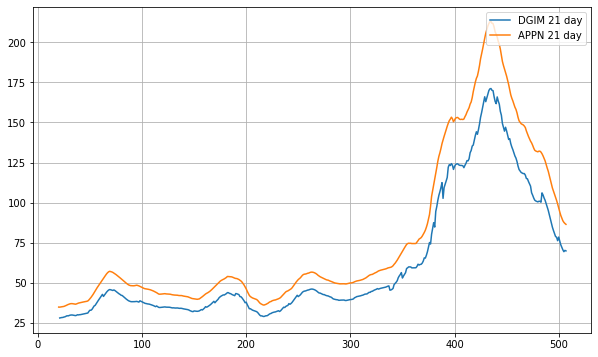

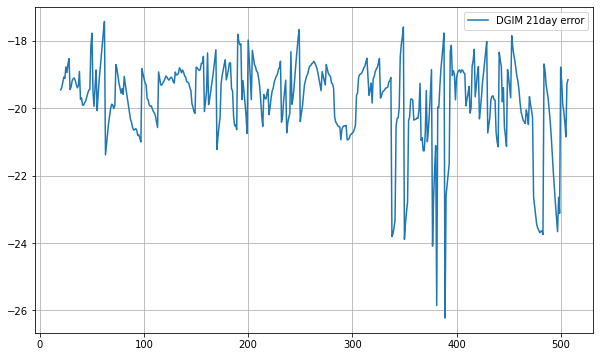

In [22]:
dgim_21day = DGIMMovingAverage(21, appn_21day_list, False)
appn['21-day-dgim'] = dgim_21day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.mov_avg, label = "DGIM 21 day")
plt.plot(range(len(dgim_21day.mov_avg)), appn_21day_list, label = "APPN 21 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.error, label = "DGIM 21day error")
plt.legend(loc=1)


In [23]:
appn.tail()

,High,Low,Open,Close,Volume,9-day,21-day,Change,position,system,9-day-dgim,21-day-dgim
Date,,,,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,84.880000,90.346190,0.023709,-1,-0.023709,66.222222,72.190476
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,85.348889,88.746190,-0.032576,-1,0.032576,65.888889,70.619048
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,86.631111,87.721428,0.070423,-1,-0.070423,67.222222,69.428571
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,87.454445,87.013333,-0.027621,1,-0.027621,68.000000,70.238095
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,88.414445,86.472857,-0.004935,1,-0.004935,68.888889,69.904762


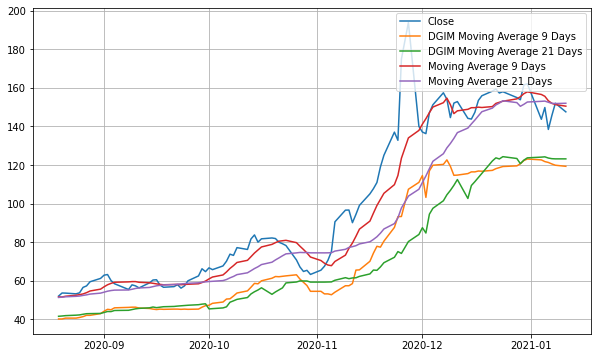

In [26]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['21-day-dgim'][-200:-100],label='DGIM Moving Average 21 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

<AxesSubplot:xlabel='Date'>

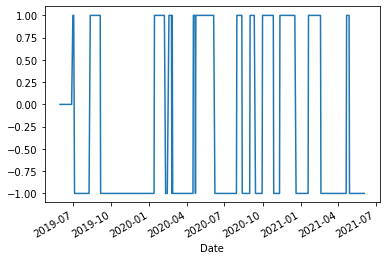

In [43]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] > appn['21-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] < appn['21-day-dgim'],-1,appn['position-dgim-9-21'])
appn['position-dgim-9-21'].plot()

<AxesSubplot:xlabel='Date'>

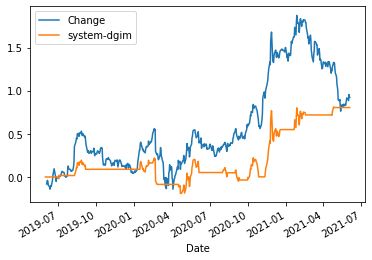

In [33]:
# Whether we are making money with this system
appn['system-dgim'] = np.where(appn['position-dgim'] > 0, appn['position-dgim']* appn['Change'],0)
appn[['Change','system-dgim']].cumsum().plot()

<AxesSubplot:xlabel='Date'>

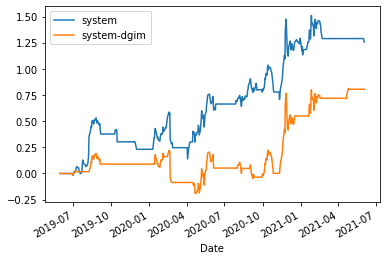

In [46]:
appn[['system','system-dgim']].cumsum().plot()

0 nan 12.0 nan
1 nan 23.0 nan
2 34.596666971842446 23.666666666666668 -31.592639585979455
3 34.12999979654948 23.333333333333332 -31.63394822026246
4 34.436667124430336 23.0 -33.21072589024402
5 33.90999984741211 23.333333333333332 -31.19040566697599
6 33.09000015258789 22.333333333333332 -32.50730362542263
7 32.13666661580404 32.0 -0.42526693087959994
8 31.89666748046875 31.666666666666668 -0.7210810155729224
9 32.006666819254555 32.0 -0.020829470598120205
10 32.38666661580404 21.666666666666668 -33.10004106414035
11 33.25999959309896 22.666666666666668 -31.85006932059698
12 34.65999984741211 24.0 -30.755914294119766
13 36.41333262125651 26.0 -28.597581906517565
14 37.79666646321615 26.0 -31.210864785381816
15 38.78000005086263 28.333333333333332 -26.93828443483182
16 38.45666758219401 28.0 -27.19077923183234
17 37.23666636149088 26.666666666666668 -28.385998875977286
18 35.43000030517578 24.666666666666668 -30.379151977982783
19 35.1933339436849 24.333333333333332 -30.858118266741503

301 52.68166732788086 36.0 -31.66503296878832
302 50.914999643961586 35.0 -31.25797850388294
303 49.88833363850912 34.0 -31.847793822170907
304 50.936667124430336 34.666666666666664 -31.941627468516142
305 51.880001068115234 35.333333333333336 -31.8941160256669
306 52.18000030517578 36.0 -31.0080494644437
307 51.936665852864586 36.0 -30.684807334403796
308 52.153333028157554 35.0 -32.89019518445059
309 52.78666687011719 35.666666666666664 -32.43243269285155
310 53.12666702270508 36.0 -32.23742045663348
311 53.516666412353516 36.333333333333336 -32.108377129883536
312 53.5533332824707 36.333333333333336 -32.154861133123696
313 54.54333368937174 38.666666666666664 -29.10835467652904
314 55.913333892822266 40.0 -28.460713724074857
315 57.81999969482422 39.333333333333336 -31.972788756596493
316 59.37000020345052 40.666666666666664 -31.50300399644742
317 61.22333272298177 41.333333333333336 -32.48761298187579
318 62.46999994913737 42.0 -32.76772845494461
319 62.09999974568685 42.0 -32.3671

461 131.55333455403647 127.33333333333333 -3.207825354643324
462 128.98333231608072 127.33333333333333 -1.2792342647063717
463 132.52333323160806 132.0 -0.39489893503768553
464 134.7933349609375 92.0 -31.74736716273013
465 136.06000264485678 93.33333333333333 -31.402813818142
466 133.77999877929688 91.0 -31.977873501010446
467 134.11666361490884 91.33333333333333 -31.90008543936041
468 133.25666300455728 89.66666666666667 -32.71130715347409
469 133.0133310953776 89.66666666666667 -32.58821057389283
470 133.86000061035156 90.66666666666667 -32.26754351317753
471 134.00999959309897 91.0 -32.094619598307816
472 136.63999938964844 93.66666666666667 -31.450038725803257
473 135.8133290608724 92.66666666666667 -31.76909268961894
474 132.89666493733725 132.33333333333334 -0.4238869382234125
475 127.13999938964844 127.0 -0.11011435450725357
476 123.4933344523112 83.33333333333333 -32.51997469910917
477 122.80333455403645 82.66666666666667 -32.68369546570307
478 125.85000356038411 125.6666666666

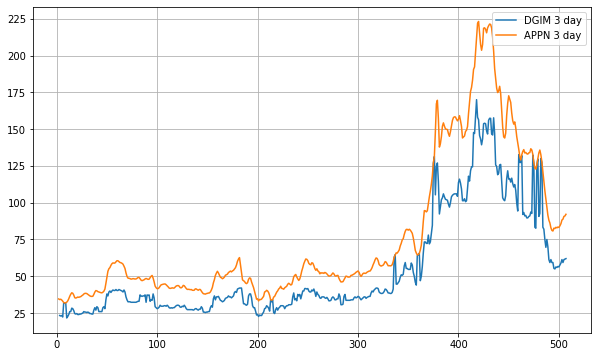

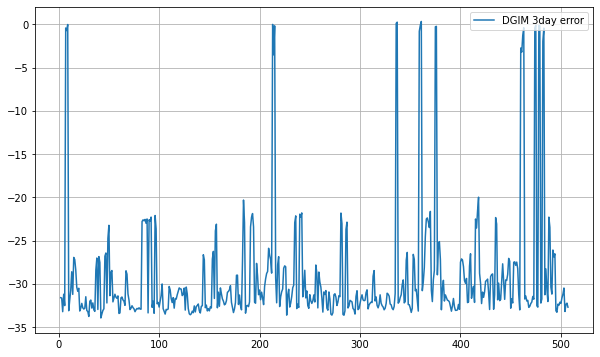

In [38]:
dgim_3day = DGIMMovingAverage(3, appn_3day_list, False)
appn['3-day-dgim'] = dgim_3day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_3day.mov_avg)), dgim_3day.mov_avg, label = "DGIM 3 day")
plt.plot(range(len(dgim_3day.mov_avg)), appn_3day_list, label = "APPN 3 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_3day.error)), dgim_3day.error, label = "DGIM 3day error")
plt.legend(loc=1)

In [39]:
appn.tail()

,High,Low,Open,Close,Volume,9-day,21-day,Change,position,system,9-day-dgim,21-day-dgim,position-dgim,system-dgim,3-day,3-day-dgim
Date,,,,,,,,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,84.880000,90.346190,0.023709,-1,0.000000,66.222222,72.190476,-1,0.0,88.220001,61.333333
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,85.348889,88.746190,-0.032576,-1,0.000000,65.888889,70.619048,-1,0.0,88.806669,59.333333
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,86.631111,87.721428,0.070423,-1,0.000000,67.222222,69.428571,-1,0.0,90.676669,61.333333
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,87.454445,87.013333,-0.027621,1,-0.027621,68.000000,70.238095,-1,0.0,90.986669,61.666667
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,88.414445,86.472857,-0.004935,1,-0.004935,68.888889,69.904762,-1,0.0,92.113335,62.000000


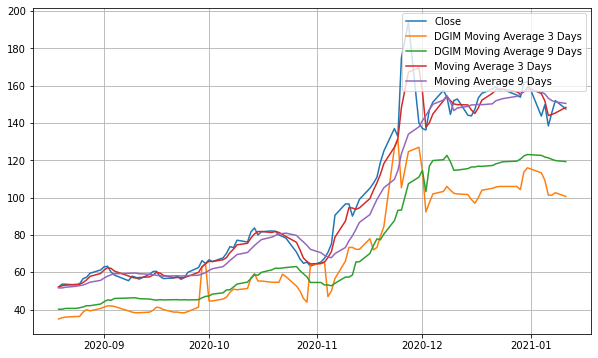

In [40]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day-dgim'][-200:-100],label='DGIM Moving Average 3 Days')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.legend(loc=1)

<AxesSubplot:xlabel='Date'>

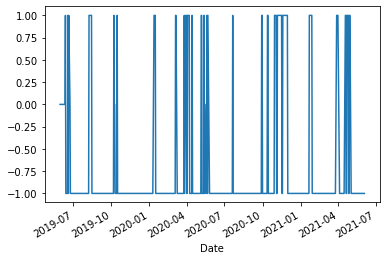

In [44]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] > appn['9-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] < appn['9-day-dgim'],-1,appn['position-dgim-3-9'])
appn['position-dgim-3-9'].plot()

<AxesSubplot:xlabel='Date'>

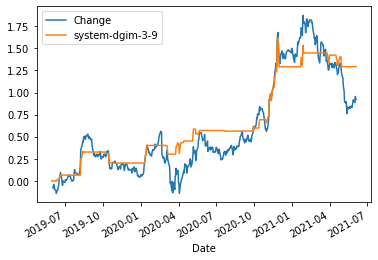

In [45]:
# Whether we are making money with this system
appn['system-dgim-3-9'] = np.where(appn['position-dgim-3-9'] > 0, appn['position-dgim-3-9']* appn['Change'],0)
appn[['Change','system-dgim-3-9']].cumsum().plot()

<AxesSubplot:xlabel='Date'>

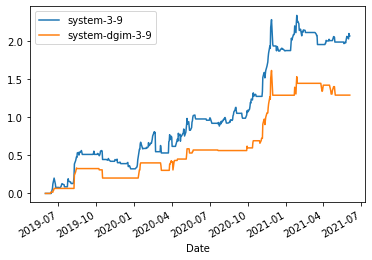

In [49]:
appn[['system-3-9','system-dgim-3-9']].cumsum().plot()

<AxesSubplot:xlabel='Date'>

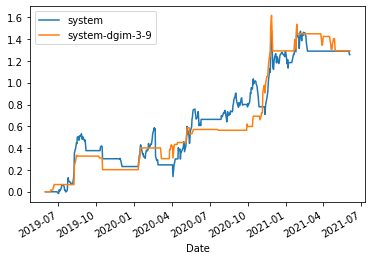

In [50]:
appn[['system','system-dgim-3-9']].cumsum().plot()